<h1>formula 1 Race Data</h1>
<blockquote>Formula One, also called F1 in short, is an international auto racing sport. F1 is the highest level of single-seat, open-wheel and open-cockpit professional motor racing contest.

<br>Formula One racing is governed and sanctioned by a world body called the FIA − Fédération Internationale de l'Automobile or the International Automobile Federation. The name ‘Formula’ comes from the set of rules that the participating cars and drivers must follow.</blockquote>
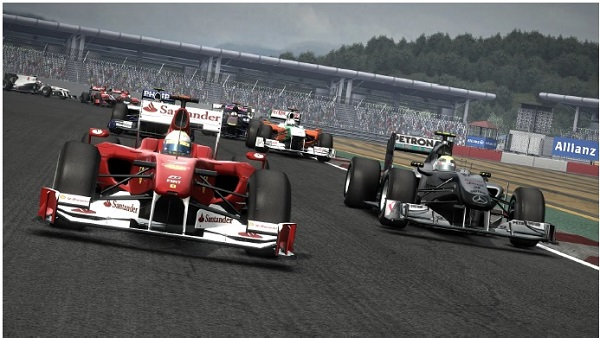
<hr>

<h2>Import Data</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results=pd.read_csv('results.csv',usecols=['raceId','driverId','constructorId','grid','rank','points'])
results.replace('\\N',np.nan,inplace=True)
results['rank']=results['rank'].astype(float)
results.head(3)

,raceId,driverId,constructorId,grid,points,rank
0,18,1,1,1,10.0,2.0
1,18,2,2,5,8.0,3.0
2,18,3,3,7,6.0,5.0


In [2]:
races=pd.read_csv('races.csv',usecols=['raceId','circuitId','name'])
races.head(3)

,raceId,circuitId,name
0,1,1,Australian Grand Prix
1,2,2,Malaysian Grand Prix
2,3,17,Chinese Grand Prix


<h2>Exploring weakness and strength of Red Bull team.</h2>
<hr>
<h3>Red Bull's statistics in each circuit.</h3>
<blockquote>
    The more information we have the more chance we can win. Even we can't choose the circuit but atleast know where is place we belong to it could help us.</blockquote>

In [3]:
RBcircuits=pd.merge(left=results,right=races,how='outer',on='raceId')

#get circuit' names.
circuit=pd.read_csv('circuits.csv')
RBcircuits=pd.merge(left=RBcircuits,right=circuit,how='left',on='circuitId')
RBcircuits.rename(columns={'name_y':'CircuitName'},inplace=True)

#select attributes
RBcircuits=RBcircuits[['raceId', 'driverId', 'constructorId', 'grid', 'points', 'rank','circuitId','CircuitName']]

#select only Red bull team
RBcircuits=RBcircuits[RBcircuits['constructorId']==9]

RBcircuits['circuitId']=RBcircuits['circuitId'].astype(str)
RBcircuits.head(3)

,raceId,driverId,constructorId,grid,points,rank,circuitId,CircuitName
13,18,14.0,9.0,8.0,0.0,11.0,1,Albert Park Grand Prix Circuit
16,18,17.0,9.0,14.0,0.0,NaN,1,Albert Park Grand Prix Circuit
28,19,17.0,9.0,6.0,2.0,12.0,2,Sepang International Circuit


In [4]:
#Average point in each circuit
RBcircuitsAvgPoint=RBcircuits[['CircuitName','points','rank']].groupby('CircuitName').agg('mean').sort_values('points',ascending=False)
RBcircuitsAvgPoint.style.background_gradient()

,points,rank
CircuitName,,
Buddh International Circuit,17.000000,5.500000
Korean International Circuit,13.500000,5.750000
Marina Bay Street Circuit,11.750000,5.708333
Autódromo Hermanos Rodríguez,11.700000,5.500000
Yas Marina Circuit,11.666667,5.000000
Autódromo Internacional do Algarve,11.250000,3.500000
Circuit Paul Ricard,10.750000,7.250000
Suzuka Circuit,10.692308,6.615385
Circuit de Monaco,9.833333,8.100000


In [5]:
RBcircuitsAvgRank=RBcircuits[['CircuitName','points','rank']].groupby('CircuitName').agg('mean').sort_values('rank')
RBcircuitsAvgRank.rename(columns={'rank':'ranks'},inplace=True)
RBcircuitsAvgRank.style.background_gradient()

,points,ranks
CircuitName,,
Autodromo Internazionale del Mugello,7.500000,1.500000
Autódromo Internacional do Algarve,11.250000,3.500000
Yas Marina Circuit,11.666667,5.000000
Autódromo Hermanos Rodríguez,11.700000,5.500000
Buddh International Circuit,17.000000,5.500000
Marina Bay Street Circuit,11.750000,5.708333
Korean International Circuit,13.500000,5.750000
Silverstone Circuit,9.264706,5.878788
Hungaroring,8.968750,6.166667


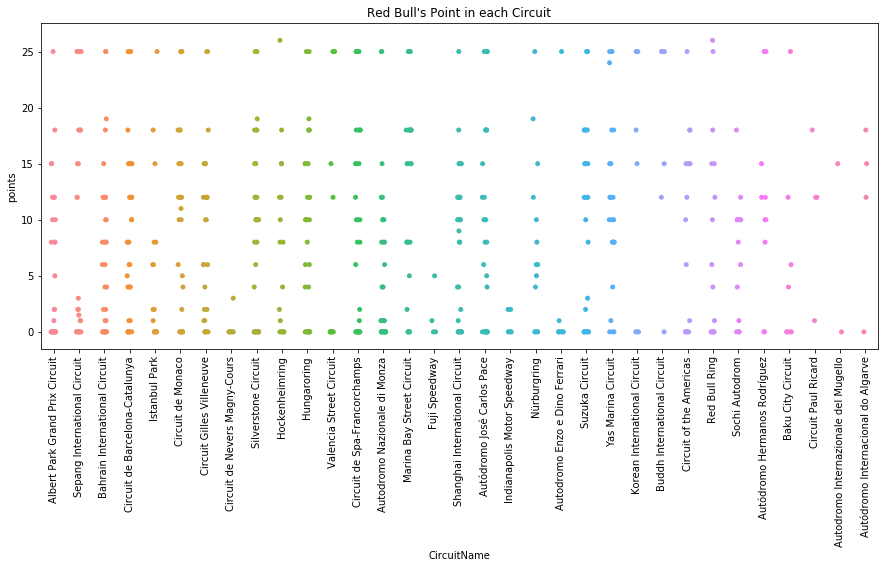

In [6]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(15,6))
plt.title("Red Bull's Point in each Circuit")
plt.xticks(rotation=90)
plt.xlabel("Circuits name")
sns.stripplot(x=RBcircuits.CircuitName,y=RBcircuits.points)

<blockquote>Above picture reveals information that Red bull took the first place from almost every circuits.(25 points means you are the first place of the race) Except for <b> "Circuit de Nevers Magny-Cours", "Indianapolis Motor Speedway" and "Fuji SpeedWay". </b>We have to figure it out Why ?? May be because of Driver not familiar to the circuit ?</blockquote>


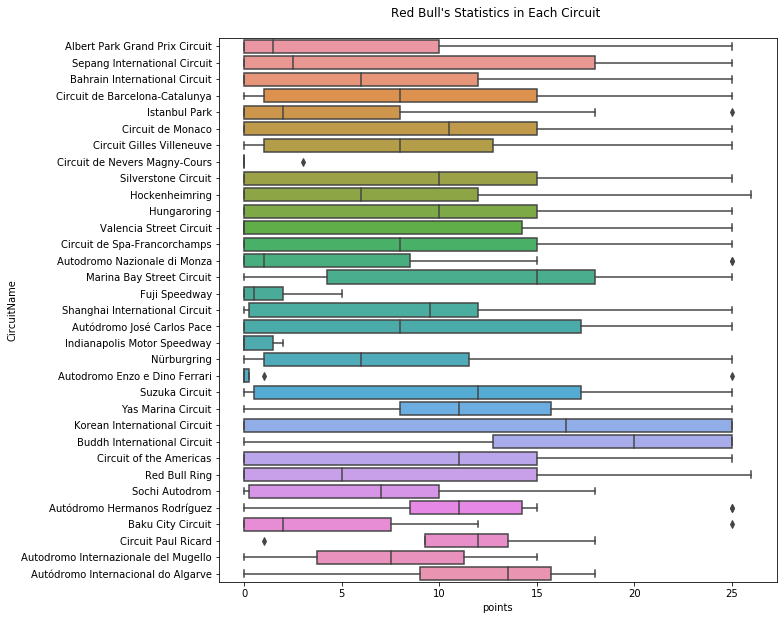

In [7]:
plt.figure(figsize=(10,10))
plt.title("Red Bull's Statistics in Each Circuit \n")
sns.boxplot(y='CircuitName',x='points',data=RBcircuits)
plt.xlabel("points")
plt.show()

<blockquote>This box plot reveals that Red Bull not doing well at <b> Circuit de Nevers Magny-Cours, Autodromo Enzo e Dino Ferrari, Fuji Speedway and Indianapolis Motor Speedway.</b> But very impressive at <b>Buddh International Circuit</b> And also gain <b>extra points at Red Bull Ring.</b> (25+1 points for fastest lap)</blockquote>

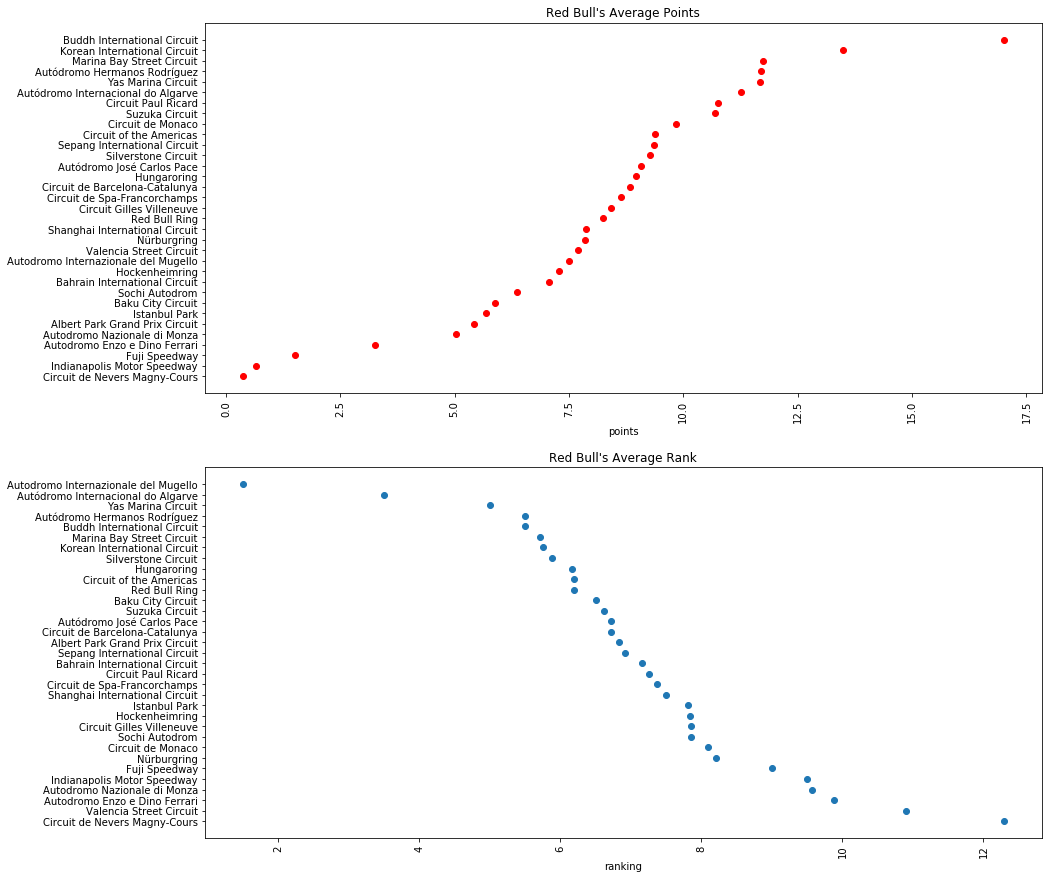

In [8]:
RBcircuitsAvgPoint=RBcircuits[['CircuitName','points','rank']].groupby('CircuitName').agg('mean').sort_values('points')

RBcircuitsAvgRank=RBcircuits[['CircuitName','points','rank']].groupby('CircuitName').agg('mean').sort_values('rank',ascending=False)
RBcircuitsAvgRank.rename(columns={'rank':'ranks'},inplace=True)
RBcircuitsAvgRank=RBcircuitsAvgRank.reset_index()
RBcircuitsAvgPoint=RBcircuitsAvgPoint.reset_index()
plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
plt.title("Red Bull's Average Points")
plt.xlabel("points")
plt.xticks(rotation=90)
plt.scatter(y=RBcircuitsAvgPoint.CircuitName,x=RBcircuitsAvgPoint.points,color='red')

plt.subplot(2,1,2)
plt.title("Red Bull's Average Rank")
plt.xlabel("ranking")
plt.xticks(rotation=90)
plt.scatter(y=RBcircuitsAvgRank.CircuitName,x=RBcircuitsAvgRank.ranks)


<blockquote>Most of points Red Bull gain is in range between 5 to 12 which are the 4th place to 7th place according to F1 points system.</blockquote>
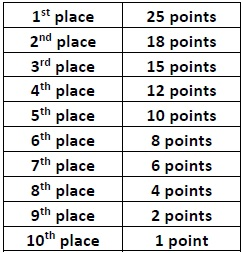
<hr>

<h2>Statistics lap time in each circuit</h2>
<blockquote>lap time is the time it takes driver to finish in between splits.
<br>In each circuit have difference distance in one lap and other factors that effecting lap time. It's a good information to know stat in each circuit.
    <br><b>Remember that in lap time the lowest time spending is the best lap time.</b> (Fastest lap)</blockquote>

In [29]:
laps=pd.read_csv('lap_times.csv')
circuitname=RBcircuits[['raceId','CircuitName']]

#statistic in each circuit
laps=pd.merge(left=laps,right=circuitname,how='left',on='raceId')

#transform millisecond to time format in minute that esier to read.
#percentage == 0 mean fastest and 0.25,0.5 are slower in consequence
laps['TimeInLap']=laps['milliseconds'].apply(lambda x: x/1000)

#Calculate percentile function
def percentile(n):
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

#groupby circuit
laps=laps[['CircuitName','TimeInLap']].groupby(['CircuitName']).agg([percentile(0),percentile(25),percentile(50)]).reset_index()


laps.columns=laps.columns.droplevel(0)
laps.rename(columns={'':'CircuitName'},inplace=True)
laps.head()

,CircuitName,percentile_0,percentile_25,percentile_50
0,Albert Park Grand Prix Circuit,85.235,89.68200,91.9820
1,Autodromo Enzo e Dino Ferrari,75.484,80.61350,85.6650
2,Autodromo Internazionale del Mugello,78.833,82.91400,84.3125
3,Autodromo Nazionale di Monza,81.504,85.81325,87.9350
4,Autódromo Hermanos Rodríguez,78.741,82.02900,83.6590


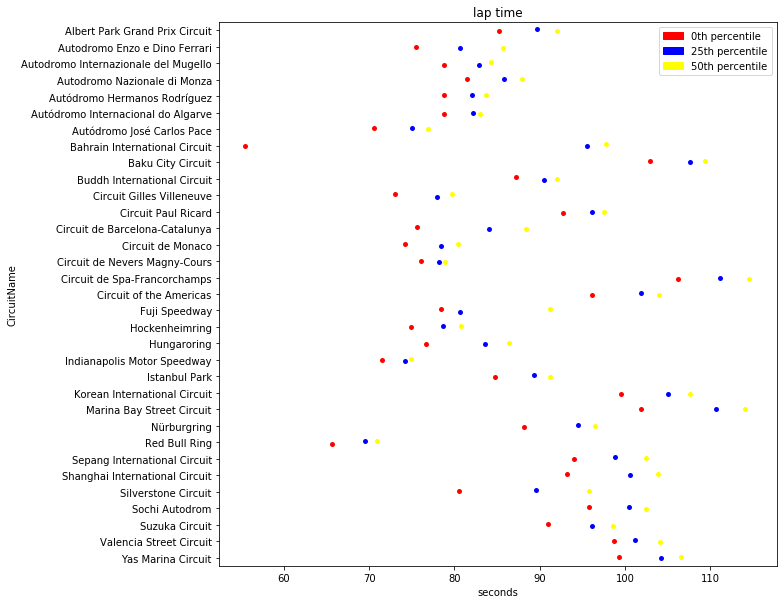

In [31]:
plt.figure(figsize=(10,10))
plt.title("lap time")
ax=sns.stripplot(y='CircuitName',x='percentile_0',data=laps,color='red')
sns.stripplot(y='CircuitName',x='percentile_25',data=laps,color='blue',ax=ax)
sns.stripplot(y='CircuitName',x='percentile_50',data=laps,color='yellow',ax=ax)
plt.xlabel("seconds")

#legend
import matplotlib.patches as mpatches
red = mpatches.Patch(color='red', label='0th percentile')
blue = mpatches.Patch(color='blue', label='25th percentile')
olive = mpatches.Patch(color='yellow', label='50th percentile')
plt.legend(handles=[red,blue,olive])

<blockquote>To be sure that we're not gonna lose, the driver must drive at lest as fast as 25th quantile fast lap of each circuit.</blockquote> 
<hr>

<h3>Pit Stop & Ranking</h3>
<blockquote>Pit stop can consume your time. Want to know how often each teams pit ? </blockquote>

In [11]:
#see how often they in pit stop
PitStops=pd.read_csv('pit_stops.csv')

PitStops=pd.merge(left=results,right=PitStops,how='inner',on=['raceId','driverId'])

df=PitStops.groupby(['raceId','driverId'])
maxPit=df.stop.max().reset_index()

PitStops=pd.merge(left=PitStops,right=maxPit,how='inner',on=['raceId','driverId'])

PitStops=PitStops.drop(['stop_x','lap','time','duration','milliseconds'],axis=1)
PitStops=PitStops.drop_duplicates().set_index(['raceId','driverId','constructorId'])
PitStops.rename(columns={'stop_y':'StopTimes'},inplace=True)
PitStops.points.replace(0,np.nan,inplace=True)
PitStops.head(3)

grid  points  rank  StopTimes
raceId driverId constructorId                               
841    20       9                 1    25.0   4.0          2
       1        1                 2    18.0   8.0          2
       808      4                 6    15.0   7.0          2

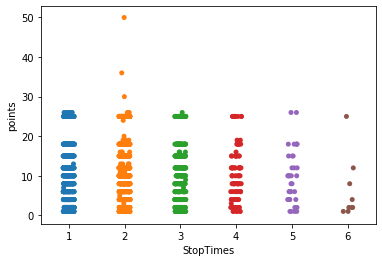

In [12]:
sns.stripplot(x='StopTimes',y='points',data=PitStops)

<blockquote>You'll see that most teams pit 2 times. And teams with highest points have pitted 2 times too.</blockquote>

<h2>Exploratory correlation</h2>
<hr>


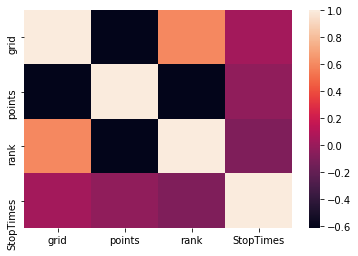

In [13]:
sns.heatmap(PitStops.corr())

<blockquote>There is a moderate correlation between grid positions (order of starting position) and rank in positive direction, and in negative direction there is a moderate correlation between grid and rank. that means as the grid order is increased, the number of points decreases.</blockquote>
<hr>

<h2>Qualifying is important !</h2>
<br>
To get the very first grid your drivers need to do well in qualifying. Based on the best time of your lap time. Here are some rules.
<blockquote>
    <b>The first qualifying period (Q1)</b> is eighteen minutes long, with all twenty cars competing. At the end of Q1, the five slowest drivers are eliminated from further qualification rounds, and fill positions sixteen to twenty on the grid based on their fastest lap time. Any driver attempting to set a qualifying time when the period ends is permitted to finish his lap, though no new laps may be started once the chequered flag is shown. After a short break, the second period (Q2) begins, with fifteen cars on the circuit. At the end of Q2, the five slowest drivers are once again eliminated, filling grid positions eleven to fifteen. Finally, the third qualifying period (Q3)</blockquote>


In [14]:
#best time in qualifying 
qualifying=pd.read_csv('qualifying.csv')

#get name of circuit
qualifying=pd.merge(left=qualifying,right=circuitname,how='left',on='raceId')[['CircuitName','driverId','q1','q2','q3']]
qualifying.replace('\\N',np.nan,inplace=True)
qualifying.head(3)

,CircuitName,driverId,q1,q2,q3
0,Albert Park Grand Prix Circuit,1,1:26.572,1:25.187,1:26.714
1,Albert Park Grand Prix Circuit,1,1:26.572,1:25.187,1:26.714
2,Albert Park Grand Prix Circuit,9,1:26.103,1:25.315,1:26.869


In [15]:
#transform data to seconds
qualifying['q1sec']=qualifying['q1'].apply(lambda x: int(x[0])*60+int(x[2:4])+int(x[5:9])/1000 if isinstance(x,str) and x[1]==':' else np.nan)
qualifying['q2sec']=qualifying['q2'].apply(lambda x: int(x[0])*60+int(x[2:4])+int(x[5:9])/1000 if isinstance(x,str) and x[1]==':' else np.nan)
qualifying['q3sec']=qualifying['q3'].apply(lambda x: int(x[0])*60+int(x[2:4])+int(x[5:9])/1000 if isinstance(x,str) and x[1]==':' else np.nan)
qualifying.head(3)

,CircuitName,driverId,q1,q2,q3,q1sec,q2sec,q3sec
0,Albert Park Grand Prix Circuit,1,1:26.572,1:25.187,1:26.714,86.572,85.187,86.714
1,Albert Park Grand Prix Circuit,1,1:26.572,1:25.187,1:26.714,86.572,85.187,86.714
2,Albert Park Grand Prix Circuit,9,1:26.103,1:25.315,1:26.869,86.103,85.315,86.869


In [16]:
qualifying=qualifying[['CircuitName','q1sec','q2sec','q3sec']].groupby(['CircuitName']).agg([percentile(0),percentile(25)]).reset_index()
qualifying.head(3)

CircuitName        q1sec                \
                                        percentile_0 percentile_25   
0        Albert Park Grand Prix Circuit       82.017      85.88925   
1         Autodromo Enzo e Dino Ferrari       74.221      75.52200   
2  Autodromo Internazionale del Mugello       75.749      76.67250   

         q2sec                      q3sec                
  percentile_0 percentile_25 percentile_0 percentile_25  
0       81.014      85.08500       80.486        84.443  
1       74.585      75.03300       73.609        74.520  
2       75.309      75.99625       75.144        75.509

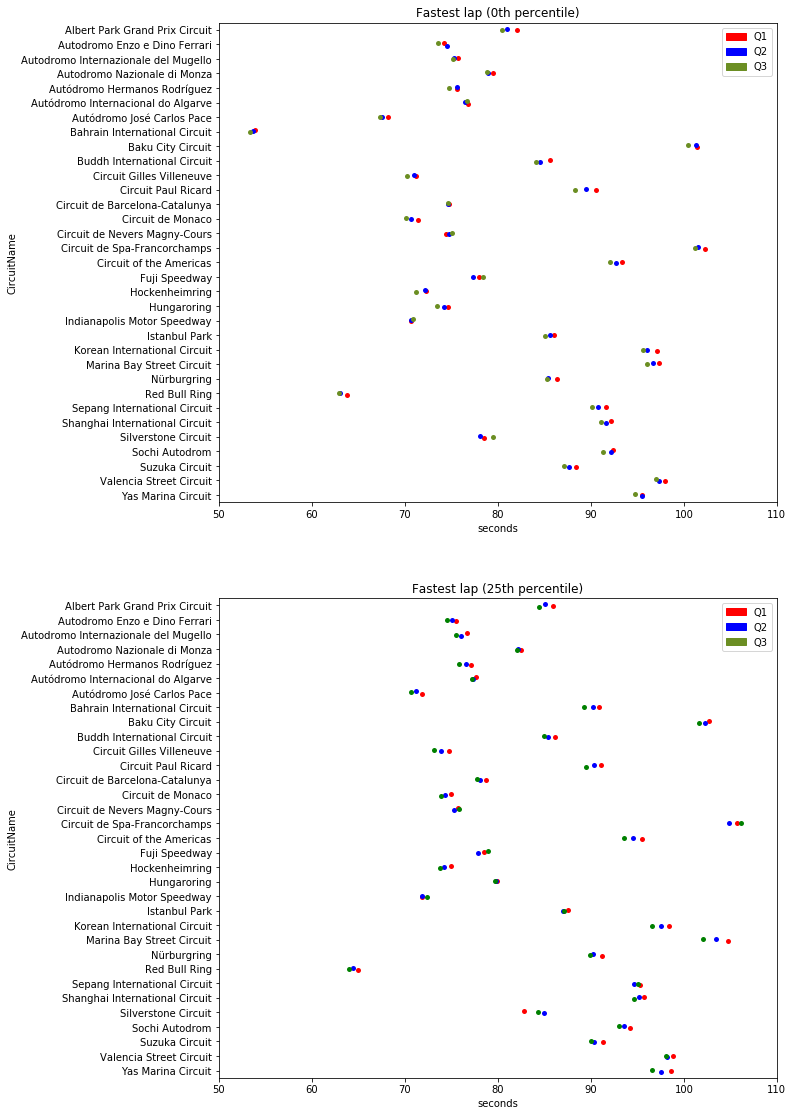

In [17]:
plt.figure(figsize=(10,30))
plt.subplot(3,1,1)
plt.title("Fastest lap (0th percentile)")
ax1=sns.stripplot(y='CircuitName',x=qualifying.q1sec.percentile_0,data=qualifying,color='red')
sns.stripplot(y='CircuitName',x=qualifying.q2sec.percentile_0,data=qualifying,color='blue',ax=ax1)
sns.stripplot(y='CircuitName',x=qualifying.q3sec.percentile_0,data=qualifying,color='olivedrab',ax=ax1)
ax1.set_xlim(50,110)
plt.xlabel("seconds")

#legend
red = mpatches.Patch(color='red', label='Q1')
blue = mpatches.Patch(color='blue', label='Q2')
olive = mpatches.Patch(color='olivedrab', label='Q3')
plt.legend(handles=[red,blue,olive])

plt.subplot(3,1,2)
plt.title("Fastest lap (25th percentile)")
ax2=sns.stripplot(y='CircuitName',x=qualifying.q1sec.percentile_25,data=qualifying,color='red')
sns.stripplot(y='CircuitName',x=qualifying.q2sec.percentile_25,data=qualifying,color='blue',ax=ax2)
sns.stripplot(y='CircuitName',x=qualifying.q3sec.percentile_25,data=qualifying,color='green',ax=ax2)
ax2.set_xlim(50,110)
plt.xlabel("seconds")

#legend
red = mpatches.Patch(color='red', label='Q1')
blue = mpatches.Patch(color='blue', label='Q2')
olive = mpatches.Patch(color='olivedrab', label='Q3')
plt.legend(handles=[red,blue,olive])

<blockquote>You need to faster than 25th percentile to make sure you'll get in next round of qualifying.</blockquote>

<hr>
<h3>Never forget to find drivers for our team!</h3>
<blockquote>The drivers are one of the most important keys to victory, along with the constructor team. But it would be too lazy to pick drivers based only on their point average. Think about it, if you pick drivers based only on his or her high point average, but they have been dire for a while, that's not a good idea. So we also look at the change in their performance together.
</blockquote>

In [26]:
drivers=pd.read_csv('driver_standings.csv',usecols=['points','wins','driverId','raceId'])

#get name and round of raceIds
raceYear=pd.read_csv('races.csv',usecols=['raceId','year','round'])
drivers=pd.merge(left=drivers,right=raceYear,how='left',on=['raceId'])

#mean of points drivers get
drivers=drivers.groupby(['driverId','year'])['points'].mean().to_frame()
drivers.sort_index(inplace=True)
drivers.head()

points
driverId year            
1        2007   64.470588
         2008   52.888889
         2009   21.062500
         2010  127.105263
         2011  125.315789

In [27]:
#find differencing of points in each year(Change in performance)
drivers['diffs']=np.nan
idx = pd.IndexSlice

for ix in drivers.index.levels[0]:
    drivers.loc[ idx[ix,:], 'diffs'] = drivers.loc[idx[ix,:], 'points' ].diff()
    
drivers.head()

points       diffs
driverId year                        
1        2007   64.470588         NaN
         2008   52.888889  -11.581699
         2009   21.062500  -31.826389
         2010  127.105263  106.042763
         2011  125.315789   -1.789474

In [28]:
#find the average points and average of differencing point
DriverChange=drivers.groupby('driverId')['points','diffs'].mean().reset_index().sort_values(['points','diffs'],ascending=False)

#name of drivers
drivername=pd.read_csv('drivers.csv',usecols=['forename','surname','driverId'])
drivername['driverfullname']=drivername['surname']+' '+drivername['forename']

#set the index with name of drivers
DriverChange=pd.merge(left=DriverChange,right=drivername,how='left',on='driverId')
DriverChange=DriverChange.set_index('driverfullname')
DriverChange=DriverChange.drop(['driverId','forename','surname'],axis=1)

DriverChange.head(20).style.background_gradient()

,points,diffs
driverfullname,,
Hamilton Lewis,134.974268,-2.140756
Vettel Sebastian,105.569303,-0.136364
Bottas Valtteri,91.654189,1.947368
Verstappen Max,83.992970,1.442982
Rosberg Nico,78.997989,19.620635
Alonso Fernando,55.945107,0.088235
Leclerc Charles,55.467087,-0.126984
Ricciardo Daniel,55.189767,0.900000
Räikkönen Kimi,51.908175,-0.316993


<blockquote>Now we know <b>Hamilton Lewis</b> is the best choices after him is <b>Vettel Sebastian</b>. Their average points are great and their performance are rather stable.</blockquote>

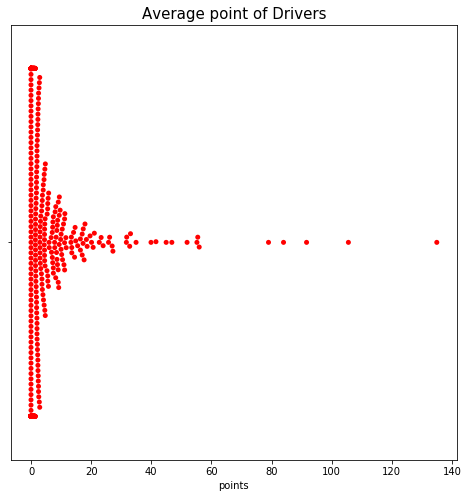

In [21]:
plt.figure(figsize=(8,8))
plt.title("Average point of Drivers",fontsize=15)
sns.swarmplot(DriverChange['points'],color='red')